# RAG Evaluations

We will walk through the evaluation workflow for RAG (retrieval augmented generation).

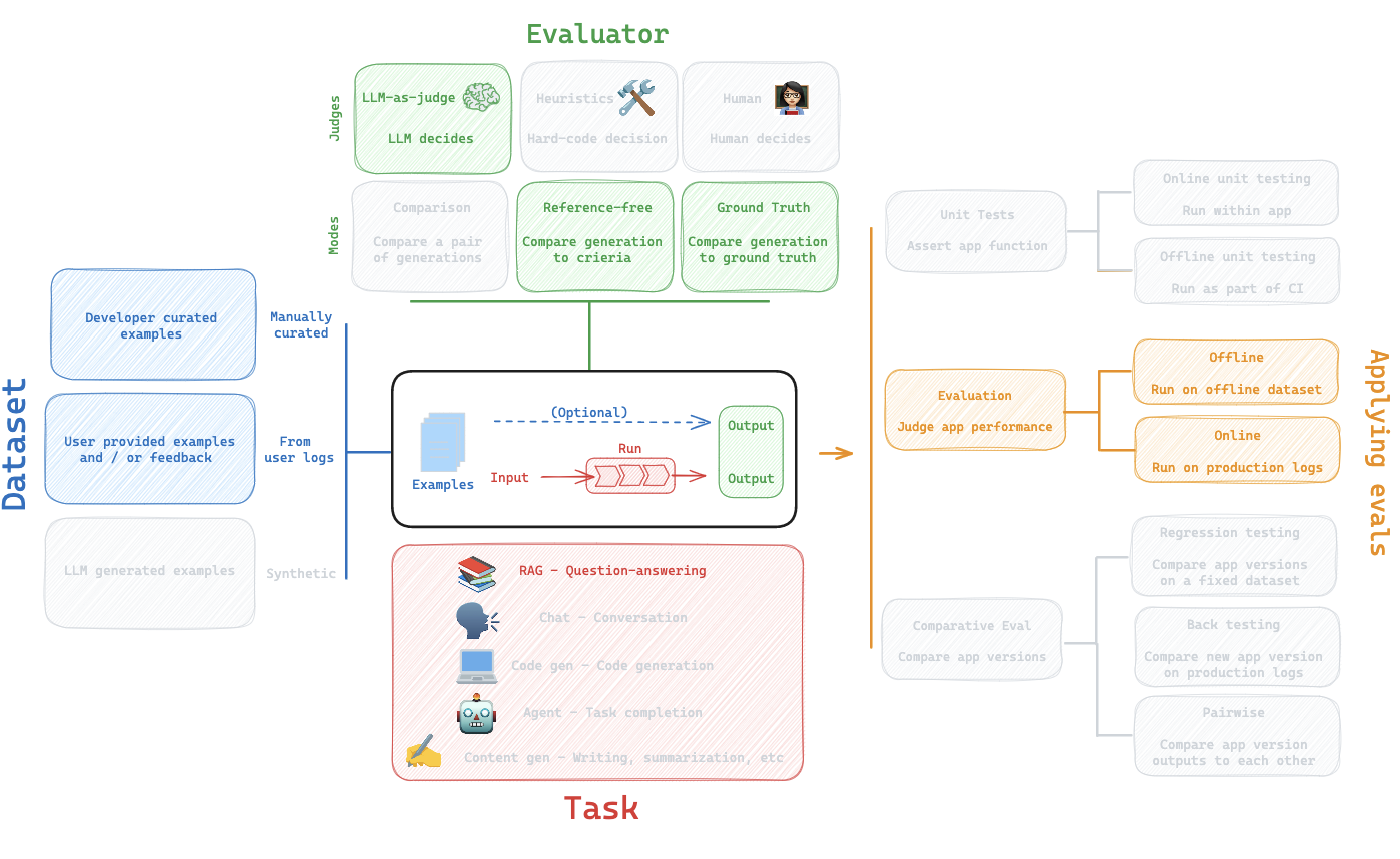



In [1]:
import os
from dotenv import load_dotenv
load_dotenv()
os.environ["LANGCHAIN_API_KEY"]=os.environ.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_PROJECT"]="langsmith-evaluations"

# Dataset
Here is a dataset of LCEL ([LangChain Expression Language](https://python.langchain.com/v0.1/docs/expression_language/)) related questions that we will use.

This dataset was created using csv upload in the LangSmith UI:

https://smith.langchain.com/public/730d833b-74da-43e2-a614-4e2ca2502606/d

In [ ]:
import langsmith

client = langsmith.Client()

# Clone the dataset to your tenant to use it
dataset_name = "LCEL-QA"

dataset_name = (
    "https://smith.langchain.com/public/730d833b-74da-43e2-a614-4e2ca2502606/d?paginationState=%7B%22pageIndex%22%3A0%2C%22pageSize%22%3A10%7D"
)
client.clone_public_dataset(dataset_name)


In [10]:

### Dataset name
dataset_name = "LCEL-QA"

# RAG Chain

In [2]:
### INDEX

from bs4 import BeautifulSoup as Soup
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Load docs
url = "https://python.langchain.com/v0.1/docs/expression_language/"
loader = RecursiveUrlLoader(
    url=url, max_depth=20, extractor=lambda x: Soup(x, "html.parser").text
)
docs = loader.load()

# Split into chunks
text_splitter = RecursiveCharacterTextSplitter(chunk_size=4500, chunk_overlap=200)
splits = text_splitter.split_documents(docs)

# Embed and store in Chroma
vectorstore = Chroma.from_documents(documents=splits, embedding=OpenAIEmbeddings())

# Index
retriever = vectorstore.as_retriever()

In [3]:
### RAG bot

import openai
from langsmith import traceable
from langsmith.wrappers import wrap_openai

class RagBot:

    def __init__(self, retriever, model: str = "gpt-4o-mini"):
        self._retriever = retriever
        # Wrapping the client instruments the LLM
        self._client = wrap_openai(openai.Client())
        self._model = model

    @traceable()
    def retrieve_docs(self, question):
        return self._retriever.invoke(question)

    @traceable()
    def invoke_llm(self, question, docs):
        response = self._client.chat.completions.create(
            model=self._model,
            messages=[
                {
                    "role": "system",
                    "content": "You are a helpful AI code assistant with expertise in LCEL."
                    " Use the following docs to produce a concise code solution to the user question.\n\n"
                    f"## Docs\n\n{docs}",
                },
                {"role": "user", "content": question},
            ],
        )

        # Evaluators will expect "answer" and "contexts"
        return {
            "answer": response.choices[0].message.content,
            "contexts": [str(doc) for doc in docs],
        }

    @traceable()
    def get_answer(self, question: str):
        docs = self.retrieve_docs(question)
        return self.invoke_llm(question, docs)

rag_bot = RagBot(retriever)

In [ ]:
response = rag_bot.get_answer("How to build a RAG chain in LCEL?")
response["answer"][:150]

# Evaluator Framework:


Define a function that will:

- Take a dataset example
- Extract the relevant key (e.g., question) from the example
- Pass it to the RAG chain
- Return the relevant output values from the RAG chain

In [8]:
def predict_rag_answer(example: dict):
    """Use this for answer evaluation"""
    response = rag_bot.get_answer(example["input_question"])
    return {"answer": response["answer"]}

def predict_rag_answer_with_context(example: dict):
    """Use this for evaluation of retrieved documents and hallucinations"""
    response = rag_bot.get_answer(example["input_question"])
    return {"answer": response["answer"], "contexts": response["contexts"]}

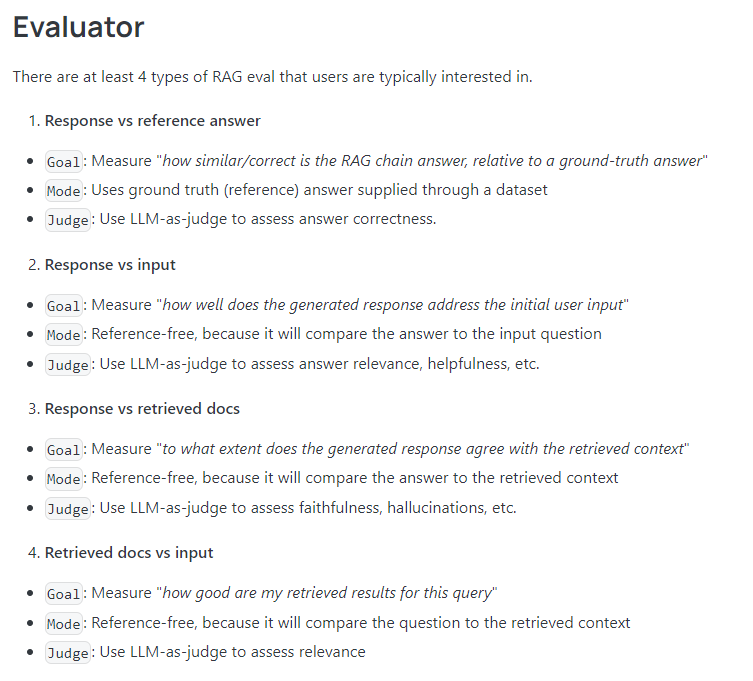

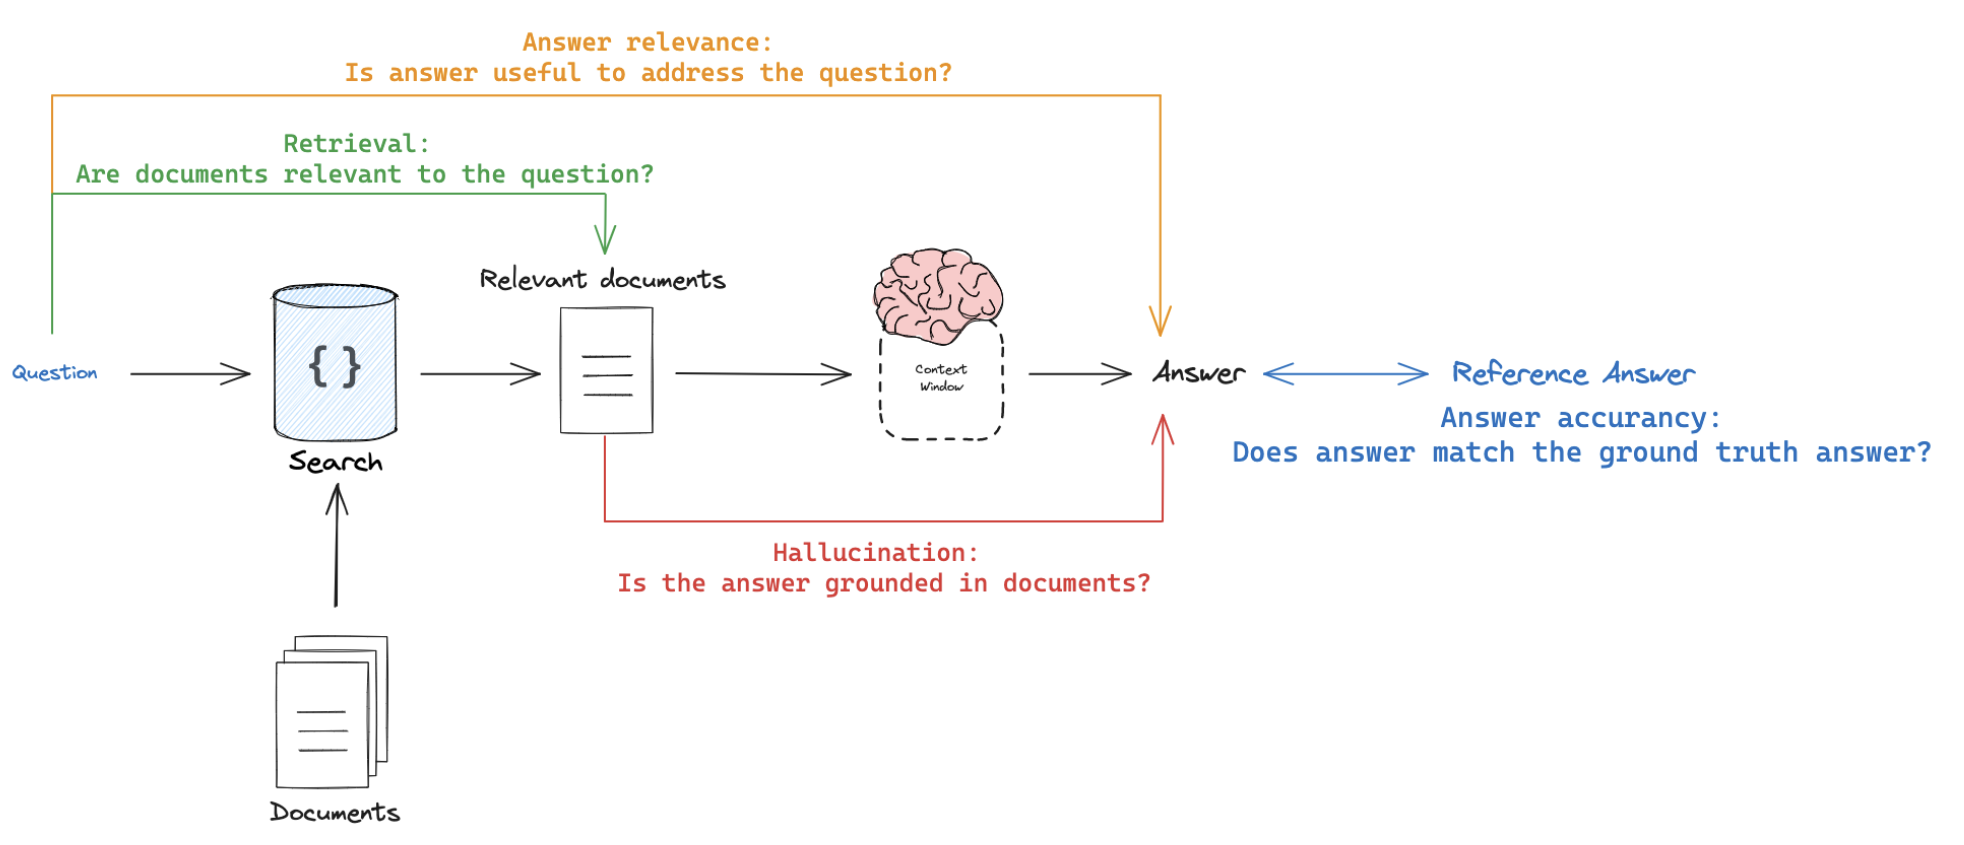

# 1. Response vs reference answer

In [4]:
from langchain import hub
from langchain_openai import ChatOpenAI

# Grade prompt
grade_prompt_answer_accuracy = prompt = hub.pull("langchain-ai/rag-answer-vs-reference")

def answer_evaluator(run, example) -> dict:
    """
    A simple evaluator for RAG answer accuracy
    """

    # Get question, ground truth answer, RAG chain answer
    input_question = example.inputs["input_question"]
    reference = example.outputs["output_answer"]
    prediction = run.outputs["answer"]

    # LLM grader
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

    # Structured prompt
    answer_grader = grade_prompt_answer_accuracy | llm

    # Run evaluator
    score = answer_grader.invoke({"question": input_question,
                                  "correct_answer": reference,
                                  "student_answer": prediction})
    score = score["Score"]

    return {"key": "answer_v_reference_score", "score": score}

c:\Code\Github\LangSmith\venv\lib\site-packages\langchain_core\_api\beta_decorator.py:87: LangChainBetaWarning: The function `loads` is in beta. It is actively being worked on, so the API may change.
  warn_beta(


Now, we kick off evaluation:

- predict_rag_answer: Takes an example from our eval set, extracts the question, passes to our RAG chain
- answer_evaluator: Passes RAG chain answer, question, and ground truth answer to an evaluator

In [11]:
from langsmith.evaluation import evaluate

experiment_results = evaluate(
    predict_rag_answer,
    data=dataset_name,
    evaluators=[answer_evaluator],
    experiment_prefix="rag-answer-v-reference",
    metadata={"version": "LCEL context, gpt-4o-mini"},
)

c:\Code\Github\LangSmith\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


View the evaluation results for experiment: 'rag-answer-v-reference-e978499d' at:
https://smith.langchain.com/o/73f54c34-84e1-5516-a9cc-5d9ae836cbdd/datasets/cd535dab-d495-45b1-848c-2c2a114a6085/compare?selectedSessions=6bc5846b-fa83-423f-a70b-a79ff8c82786




20it [00:26,  1.32s/it]


# 2. Response vs input

In [5]:
# Grade prompt
grade_prompt_answer_helpfulness = prompt = hub.pull("langchain-ai/rag-answer-helpfulness")

def answer_helpfulness_evaluator(run, example) -> dict:
    """
    A simple evaluator for RAG answer helpfulness
    """

    # Get question, ground truth answer, RAG chain answer
    input_question = example.inputs["input_question"]
    prediction = run.outputs["answer"]

    # LLM grader
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

    # Structured prompt
    answer_grader = grade_prompt_answer_helpfulness | llm

    # Run evaluator
    score = answer_grader.invoke({"question": input_question,
                                  "student_answer": prediction})
    score = score["Score"]

    return {"key": "answer_helpfulness_score", "score": score}

In [12]:
experiment_results = evaluate(
    predict_rag_answer,
    data=dataset_name,
    evaluators=[answer_helpfulness_evaluator],
    experiment_prefix="rag-answer-helpfulness",
    metadata={"version": "LCEL context, gpt-4o-mini"},
)

View the evaluation results for experiment: 'rag-answer-helpfulness-f7db56c8' at:
https://smith.langchain.com/o/73f54c34-84e1-5516-a9cc-5d9ae836cbdd/datasets/cd535dab-d495-45b1-848c-2c2a114a6085/compare?selectedSessions=762ecc87-5447-4018-ae52-9f4f4bdba6e3




20it [00:22,  1.14s/it]


# Response vs retrieved docs

In [13]:
# Prompt
grade_prompt_hallucinations = prompt = hub.pull("langchain-ai/rag-answer-hallucination")

def answer_hallucination_evaluator(run, example) -> dict:
    """
    A simple evaluator for generation hallucination
    """

    # RAG inputs
    input_question = example.inputs["input_question"]
    contexts = run.outputs["contexts"]

    # RAG answer
    prediction = run.outputs["answer"]

    # LLM grader
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

    # Structured prompt
    answer_grader = grade_prompt_hallucinations | llm

    # Get score
    score = answer_grader.invoke({"documents": contexts,
                                  "student_answer": prediction})
    score = score["Score"]

    return {"key": "answer_hallucination", "score": score}

In [14]:
experiment_results = evaluate(
    predict_rag_answer_with_context,
    data=dataset_name,
    evaluators=[answer_hallucination_evaluator],
    experiment_prefix="rag-answer-hallucination",
    metadata={"version": "LCEL context, gpt-4o-mini"},
)

View the evaluation results for experiment: 'rag-answer-hallucination-8d3123ca' at:
https://smith.langchain.com/o/73f54c34-84e1-5516-a9cc-5d9ae836cbdd/datasets/cd535dab-d495-45b1-848c-2c2a114a6085/compare?selectedSessions=9a542e1d-633d-4cd8-becd-6c7cd7bff0fa




20it [00:26,  1.33s/it]


# Retrieved docs vs input


In [16]:
# Grade prompt
grade_prompt_doc_relevance = hub.pull("langchain-ai/rag-document-relevance")

def docs_relevance_evaluator(run, example) -> dict:
    """
    A simple evaluator for document relevance
    """

    # RAG inputs
    input_question = example.inputs["input_question"]
    contexts = run.outputs["contexts"]

    # LLM grader
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

    # Structured prompt
    answer_grader = grade_prompt_doc_relevance | llm

    # Get score
    score = answer_grader.invoke({"question":input_question,
                                  "documents":contexts})
    score = score["Score"]

    return {"key": "document_relevance", "score": score}

In [17]:
experiment_results = evaluate(
    predict_rag_answer_with_context,
    data=dataset_name,
    evaluators=[docs_relevance_evaluator],
    experiment_prefix="rag-doc-relevance",
    metadata={"version": "LCEL context, gpt-4o-mini"},
)

View the evaluation results for experiment: 'rag-doc-relevance-b652a17b' at:
https://smith.langchain.com/o/73f54c34-84e1-5516-a9cc-5d9ae836cbdd/datasets/cd535dab-d495-45b1-848c-2c2a114a6085/compare?selectedSessions=9a0580c2-2d89-4b6e-812e-fcae3e5b028b




20it [00:25,  1.30s/it]


# Evaluating intermediate steps

In [19]:
from langsmith.schemas import Example, Run
from langsmith.evaluation import evaluate

def document_relevance_grader(root_run: Run, example: Example) -> dict:
    """
    A simple evaluator that checks to see if retrieved documents are relevant to the question
    """

    # Get specific steps in our RAG pipeline, which are noted with @traceable decorator
    rag_pipeline_run = next(
        run for run in root_run.child_runs if run.name == "get_answer"
    )
    retrieve_run = next(
        run for run in rag_pipeline_run.child_runs if run.name == "retrieve_docs"
    )
    contexts = "\n\n".join(doc.page_content for doc in retrieve_run.outputs["output"])
    input_question = example.inputs["input_question"]

    # LLM grader
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

    # Structured prompt
    answer_grader = grade_prompt_doc_relevance | llm

    # Get score
    score = answer_grader.invoke({"question":input_question,
                                  "documents":contexts})
    score = score["Score"]

    return {"key": "document_relevance", "score": score}

def answer_hallucination_grader(root_run: Run, example: Example) -> dict:
    """
    A simple evaluator that checks to see the answer is grounded in the documents
    """

    # RAG input
    rag_pipeline_run = next(
        run for run in root_run.child_runs if run.name == "get_answer"
    )
    retrieve_run = next(
        run for run in rag_pipeline_run.child_runs if run.name == "retrieve_docs"
    )
    contexts = "\n\n".join(doc.page_content for doc in retrieve_run.outputs["output"])

    # RAG output
    prediction = rag_pipeline_run.outputs["answer"]

    # LLM grader
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

    # Structured prompt
    answer_grader = grade_prompt_hallucinations | llm

    # Get score
    score = answer_grader.invoke({"documents": contexts,
                                  "student_answer": prediction})
    score = score["Score"]

    return {"key": "answer_hallucination", "score": score}

experiment_results = evaluate(
    predict_rag_answer,
    data=dataset_name,
    evaluators=[document_relevance_grader, answer_hallucination_grader],
    metadata={"version": "LCEL context, gpt-4o-mini"},
)

View the evaluation results for experiment: 'ordinary-ear-90' at:
https://smith.langchain.com/o/73f54c34-84e1-5516-a9cc-5d9ae836cbdd/datasets/cd535dab-d495-45b1-848c-2c2a114a6085/compare?selectedSessions=db750ad5-3337-403c-928e-665b04594418




20it [00:37,  1.89s/it]
